In [1]:

import tensorflow as tf

from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from skimage import exposure



import importlib

# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [2]:
#Data preprocessing

x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0


# Binarisierung der Bilder
threshold = 0.5  # Schwelle für weiß oder schwarz
x_train_binarized = np.where(x_train_normalized > threshold, 1, 0)

x_train_reshaped = x_train_normalized.reshape(-1, 28, 28, 1)
x_test_reshaped = x_test_normalized.reshape(-1, 28, 28, 1)

def select_balanced_subset(x, y, num_samples_per_class):
    classes = np.unique(y)
    x_subset = []
    y_subset = []

    for cls in classes:
        x_cls = x[y == cls]
        y_cls = y[y == cls]
        idx = np.random.choice(range(len(x_cls)), num_samples_per_class, replace=False)
        x_subset.append(x_cls[idx])
        y_subset.append(y_cls[idx])

    return np.concatenate(x_subset), np.concatenate(y_subset)

# Auswahl des ausgeglichenen Teildatensatzes
x_train_subset, y_train_subset = select_balanced_subset(x_train_binarized, y_train, 1000)

print("Größe des reduzierten Trainingsdatensatzes:", x_train_subset.shape, y_train_subset.shape)


Größe des reduzierten Trainingsdatensatzes: (10000, 28, 28) (10000,)


In [3]:
# Definition des sequenziellen Modells
marvin = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

marvin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0

In [4]:
# Definition des losses
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], marvin(x_train[sampleID-1:sampleID]).numpy()).numpy()


marvin.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


tf.Tensor(2.3025851, shape=(), dtype=float32)


In [5]:
#Training des Models
import datetime
import os
import tensorflow as tf


marvin.fit(
    x_train_subset,
    y_train_subset,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)


Epoch 1/15
313/313 [==============================] - 11s 28ms/step - loss: 0.8317 - accuracy: 0.7709 - val_loss: 28.7286 - val_accuracy: 0.9206
Epoch 2/15
313/313 [==============================] - 6s 18ms/step - loss: 0.2554 - accuracy: 0.9225 - val_loss: 24.3658 - val_accuracy: 0.9378
Epoch 3/15
313/313 [==============================] - 7s 23ms/step - loss: 0.1848 - accuracy: 0.9427 - val_loss: 17.9611 - val_accuracy: 0.9588
Epoch 4/15
313/313 [==============================] - 6s 18ms/step - loss: 0.1503 - accuracy: 0.9545 - val_loss: 15.8149 - val_accuracy: 0.9636
Epoch 5/15
313/313 [==============================] - 7s 22ms/step - loss: 0.1244 - accuracy: 0.9621 - val_loss: 15.8410 - val_accuracy: 0.9648
Epoch 6/15
313/313 [==============================] - 4s 14ms/step - loss: 0.1068 - accuracy: 0.9675 - val_loss: 15.4787 - val_accuracy: 0.9673
Epoch 7/15
313/313 [==============================] - 6s 18ms/step - loss: 0.1012 - accuracy: 0.9678 - val_loss: 12.9316 - val_accuracy

In [6]:
#speichern des Models
model_name = 'marvin_binary_reducedlabel_relu_.h5'
marvin.save(model_name, save_format='h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2s 5ms/step


<ipython-input-7-75c6f97872e4>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


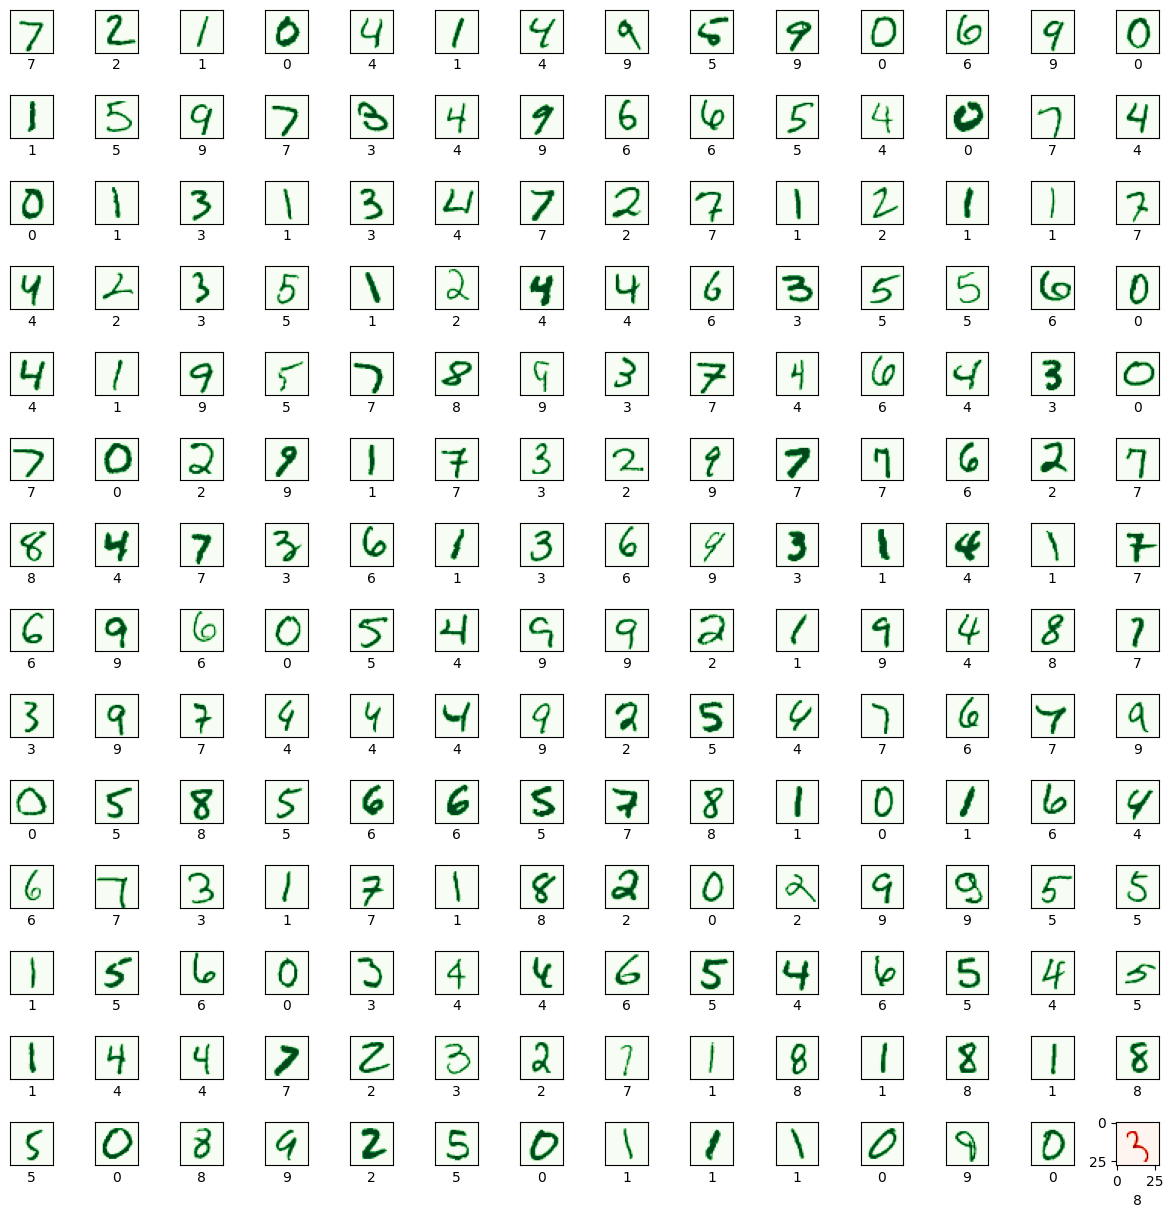

In [7]:
# laden des Models
model_name = 'marvin_binary_reducedlabel_relu_.h5'
marvin_reloaded = tf.keras.models.load_model(model_name)

# Marvin seine Prediction
predictions = marvin_reloaded.predict([x_test])

predictions = np.argmax(predictions, axis=1)
pd.DataFrame(predictions)

# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

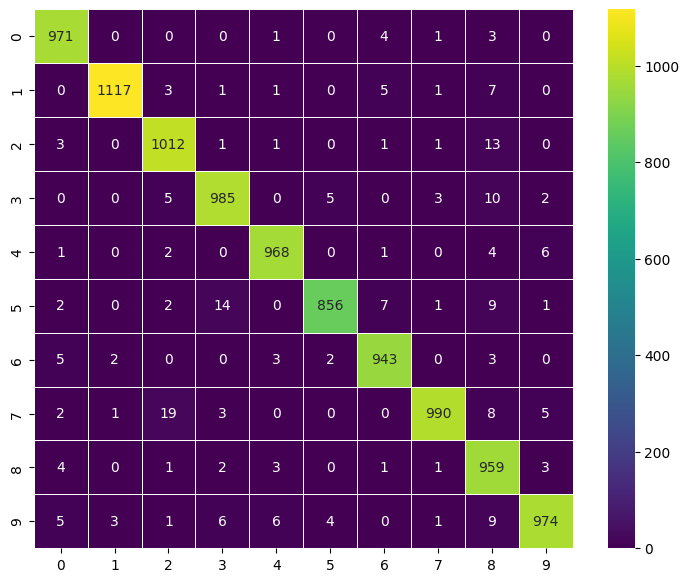

In [8]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()